<a href="https://colab.research.google.com/github/chawonlee/AI_svm_mlp_deepmlp/blob/master/cat_and_dog_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
# 기본 경로
base_dir = '/content/drive/MyDrive/archive'

training_set = os.path.join(base_dir, 'training_set')
test_set = os.path.join(base_dir, 'test_set')

# 훈련에 사용되는 고양이/개 이미지 경로
training_set_cats = os.path.join(training_set, 'cats')
training_set_dogs = os.path.join(training_set, 'dogs')
print(training_set_cats)
print(training_set_dogs)

# 테스트에 사용되는 고양이/개 이미지 경로
test_set_cats = os.path.join(test_set, 'cats')
test_set_dogs = os.path.join(test_set, 'dogs')
print(test_set_cats)
print(test_set_dogs)

/content/drive/MyDrive/archive/training_set/cats
/content/drive/MyDrive/archive/training_set/dogs
/content/drive/MyDrive/archive/test_set/cats
/content/drive/MyDrive/archive/test_set/dogs


In [11]:
print('Total training cat images :', len(os.listdir(training_set_cats)))
print('Total training dog images :', len(os.listdir(training_set_dogs)))

print('Total test cat images :', len(os.listdir(test_set_cats)))
print('Total test dog images :', len(os.listdir(test_set_dogs)))

Total training cat images : 4001
Total training dog images : 4016
Total test cat images : 1012
Total test dog images : 1013


In [12]:
training_set_cats_fnames = os.listdir( training_set_cats )
training_set_dogs_fnames = os.listdir( training_set_dogs )

print(training_set_cats_fnames[:5])
print(training_set_dogs_fnames[:5])

['cat.3698.jpg', 'cat.3669.jpg', 'cat.3685.jpg', 'cat.3683.jpg', 'cat.3684.jpg']
['dog.371.jpg', 'dog.3737.jpg', 'dog.370.jpg', 'dog.3704.jpg', 'dog.3736.jpg']


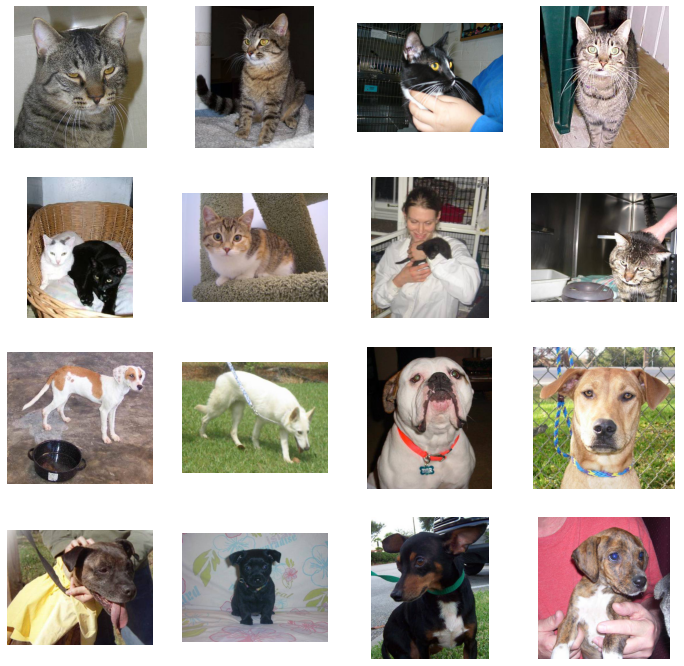

In [13]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows, ncols = 4, 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=8

next_cat_pix = [os.path.join(training_set_cats, fname)
                for fname in training_set_cats_fnames[ pic_index-8:pic_index]]

next_dog_pix = [os.path.join(training_set_dogs, fname)
                for fname in training_set_dogs_fnames[ pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()